In [44]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Set matplotlib to display plots inline (for Jupyter notebooks)
%matplotlib inline

# Step 1: Load datasets
churn_data = pd.read_csv("churn_data.csv")
customer_data = pd.read_csv("customer_data.csv")
internet_data = pd.read_csv("internet_data.csv")

# Combine datasets into one consolidated dataframe using 'customerID'
df_1 = pd.merge(churn_data, customer_data, how='inner', on='customerID')
telecom = pd.merge(df_1, internet_data, how='inner', on='customerID')

# Step 2: Inspect the dataframe
print("Dataset Head:")
print(telecom.head())
print("\nDataset Shape:", telecom.shape)
print("\nStatistical Summary:")
print(telecom.describe())
print("\nColumn Data Types:")
print(telecom.info())

# Step 3: Data Preparation

# Convert binary variables (Yes/No) to 0/1
varlist = ['PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents']
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

telecom[varlist] = telecom[varlist].apply(binary_map)

# Create dummy variables for categorical features (one-hot encoding)
dummy1 = pd.get_dummies(telecom[['Contract', 'PaymentMethod', 'gender', 'InternetService']], drop_first=True)
telecom = pd.concat([telecom, dummy1], axis=1)

# Create dummy variables for other categorical features, dropping redundant levels
ml = pd.get_dummies(telecom['MultipleLines'], prefix='MultipleLines')
ml1 = ml.drop(['MultipleLines_No phone service'], axis=1)
telecom = pd.concat([telecom, ml1], axis=1)

os = pd.get_dummies(telecom['OnlineSecurity'], prefix='OnlineSecurity')
os1 = os.drop(['OnlineSecurity_No internet service'], axis=1)
telecom = pd.concat([telecom, os1], axis=1)

ob = pd.get_dummies(telecom['OnlineBackup'], prefix='OnlineBackup')
ob1 = ob.drop(['OnlineBackup_No internet service'], axis=1)
telecom = pd.concat([telecom, ob1], axis=1)

dp = pd.get_dummies(telecom['DeviceProtection'], prefix='DeviceProtection')
dp1 = dp.drop(['DeviceProtection_No internet service'], axis=1)
telecom = pd.concat([telecom, dp1], axis=1)

ts = pd.get_dummies(telecom['TechSupport'], prefix='TechSupport')
ts1 = ts.drop(['TechSupport_No internet service'], axis=1)
telecom = pd.concat([telecom, ts1], axis=1)

st = pd.get_dummies(telecom['StreamingTV'], prefix='StreamingTV')
st1 = st.drop(['StreamingTV_No internet service'], axis=1)
telecom = pd.concat([telecom, st1], axis=1)

sm = pd.get_dummies(telecom['StreamingMovies'], prefix='StreamingMovies')
sm1 = sm.drop(['StreamingMovies_No internet service'], axis=1)
telecom = pd.concat([telecom, sm1], axis=1)

# Drop original categorical columns after creating dummies
telecom = telecom.drop(['Contract', 'PaymentMethod', 'gender', 'MultipleLines', 'InternetService', 
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                        'StreamingTV', 'StreamingMovies'], axis=1)

# Convert 'TotalCharges' to numeric, coercing errors to NaN
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'], errors='coerce')

# Check for missing values
print("\nMissing Values Before Cleaning:")
print(telecom.isnull().sum())
print("\nPercentage of Missing Values:")
print(round(100 * (telecom.isnull().sum() / len(telecom.index)), 2))

# Remove rows with NaN in 'TotalCharges'
telecom = telecom[~telecom['TotalCharges'].isnull()]

# Verify missing values after cleaning
print("\nMissing Values After Cleaning:")
print(round(100 * (telecom.isnull().sum() / len(telecom.index)), 2))

# Step 4: Test-Train Split
X = telecom.drop(['Churn', 'customerID'], axis=1)  # Features
y = telecom['Churn']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)



Dataset Head:
   customerID  tenure PhoneService        Contract PaperlessBilling  \
0  7590-VHVEG       1           No  Month-to-month              Yes   
1  5575-GNVDE      34          Yes        One year               No   
2  3668-QPYBK       2          Yes  Month-to-month              Yes   
3  7795-CFOCW      45           No        One year               No   
4  9237-HQITU       2          Yes  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges Churn  gender  ...  \
0           Electronic check           29.85        29.85    No  Female  ...   
1               Mailed check           56.95       1889.5    No    Male  ...   
2               Mailed check           53.85       108.15   Yes    Male  ...   
3  Bank transfer (automatic)           42.30      1840.75    No    Male  ...   
4           Electronic check           70.70       151.65   Yes  Female  ...   

   Partner Dependents     MultipleLines InternetService OnlineSecurity  \
0   


 26.58 %te:


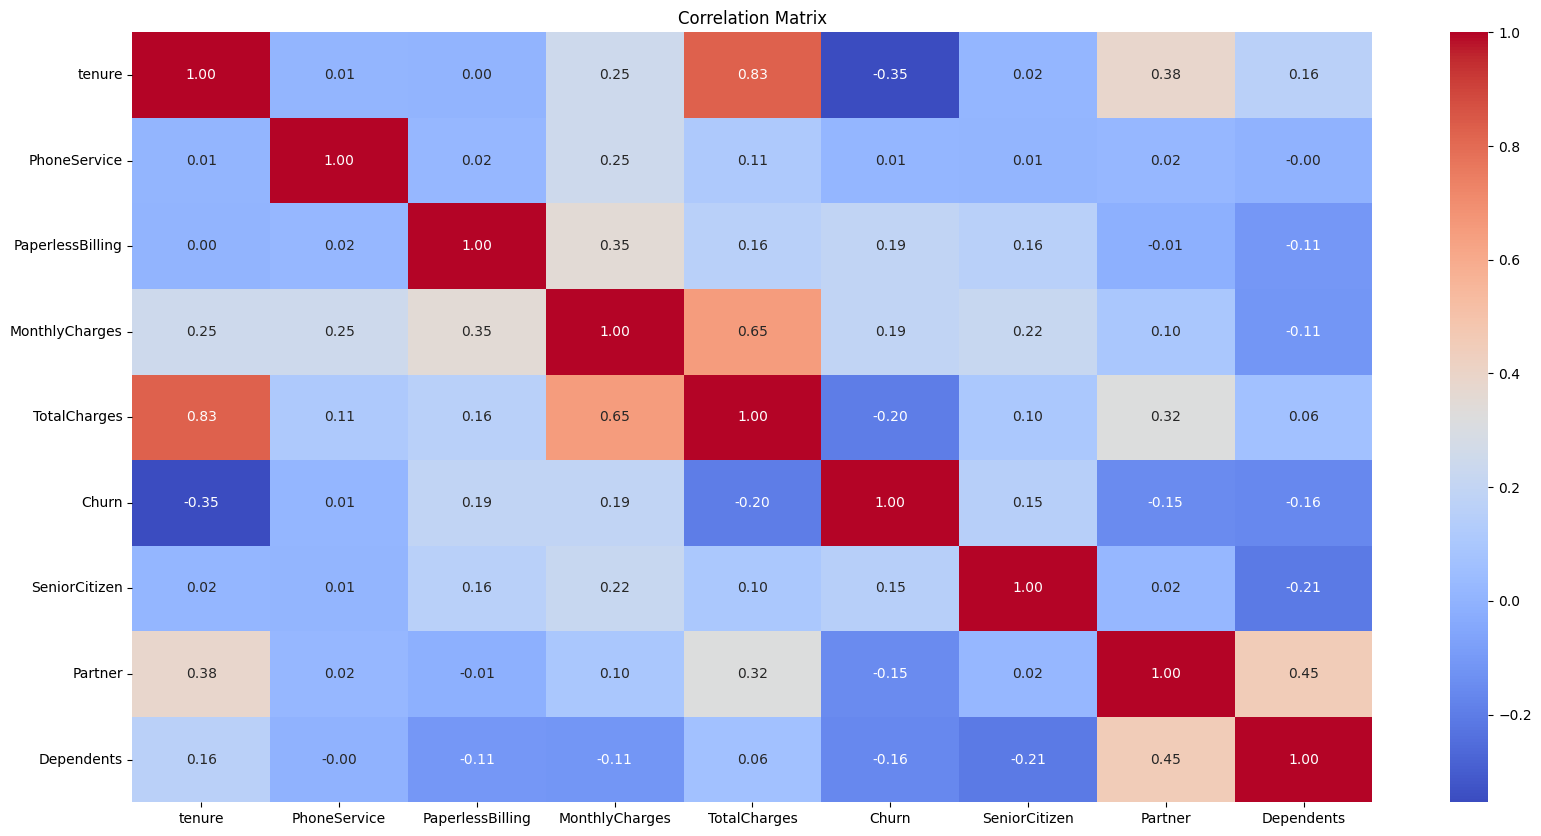

<class 'TypeError'>: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [47]:
# Step 5: Feature Scaling
scaler = StandardScaler()
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(
    X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(
    X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Check churn rate
churn_rate = (sum(telecom['Churn']) / len(telecom['Churn'])) * 100
print("\nChurn Rate:", round(churn_rate, 2), "%")

# Step 6: Correlation Analysis
# Select only numeric columns for correlation
numeric_telecom = telecom.select_dtypes(include=[np.number])
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_telecom.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

# Drop highly correlated dummy variables
X_test = X_test.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No','StreamingTV_No','StreamingMovies_No'], 1)
X_train = X_train.drop(['MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No','TechSupport_No', 'StreamingTV_No','StreamingMovies_No'], 1)

#Checking the Correlation Matrix
#After dropping highly correlated variables now let's check the correlation matrix again.
plt.figure(figsize = (20,10))
sns.heatmap(X_train.corr(),annot = True)
plt.show()


import statsmodels.api as sm

# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()